In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
%%time
input_data=[]
output_data=[]
test_data=[]
x_test_label=[]
for dirpath, dirnames, filenames in os.walk('./stage1_train'):
    if dirpath[-6:]=='images':
        #print(dirpath)
        input_data.append(dirpath+"/"+filenames[0])
    if dirpath[-5:]=='masks':
        for item in filenames:
            filenames[filenames.index(item)]=dirpath+"/"+item
        output_data.append(filenames)
#len(dirpath)
for dirpath, dirnames, filenames in os.walk('./stage1_test'):
    if dirpath[-6:]=='images':
        test_data.append(dirpath+"/"+filenames[0])
        x_test_label.append(filenames[0][:-4])

CPU times: user 124 ms, sys: 193 ms, total: 317 ms
Wall time: 674 ms


In [3]:
%%time
x_train=[]
new_size=0
for path in input_data:
    img=mpimg.imread(path)
    new_size=max(img.shape[0],img.shape[1],new_size)
    x_train.append(img)
    #plt.imshow(img[:,:,1])

y_train=[]
for ans in output_data:
    tmp=0
    for i in (ans):
        img=mpimg.imread(i)
        tmp+=img
    #plt.imshow(tmp)
    y_train.append(tmp)
    
x_test=[]
x_test_label=[]
for path in test_data:
    img=mpimg.imread(path)
    new_size=max(img.shape[0],img.shape[1],new_size)
    x_test.append(img)
    #plt.imshow(img[:,:,1])

CPU times: user 1min 57s, sys: 11.6 s, total: 2min 9s
Wall time: 2min 18s


In [4]:
%%time
BLACK = [0,0,0,1]
x_train_new=[]
y_train_new=[]
x_test_new=[]

for img1 in x_train:
    origin_height,origin_width=img1.shape[0],img1.shape[1]

    #boundary: top, bottom, left, right
    constant= cv2.copyMakeBorder(img1,0,new_size-origin_height,0,new_size-origin_width,cv2.BORDER_REPLICATE,value=BLACK)
    x_train_new.append(constant)
    
for img1 in y_train:
    origin_height,origin_width=img1.shape[0],img1.shape[1]

    #boundary: top, bottom, left, right
    constant= cv2.copyMakeBorder(img1,0,new_size-origin_height,0,new_size-origin_width,cv2.BORDER_REPLICATE,value=0)
    y_train_new.append(constant)
    

for img1 in x_test:
    origin_height,origin_width=img1.shape[0],img1.shape[1]
    #boundary: top, bottom, left, right
    constant= cv2.copyMakeBorder(img1,0,new_size-origin_height,0,new_size-origin_width,cv2.BORDER_REPLICATE,value=BLACK)
    if constant.shape[2]==3:
        
        constant=np.concatenate((constant,np.zeros((new_size,new_size,1))),axis=2)
    x_test_new.append(constant)

CPU times: user 10.9 s, sys: 13.1 s, total: 24.1 s
Wall time: 25.5 s


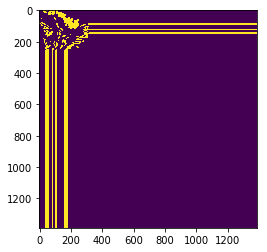

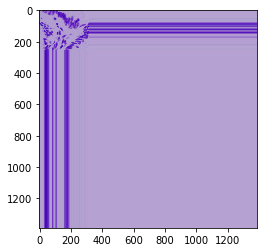

In [5]:

plt.imshow(y_train_new[2])
plt.show()
plt.imshow(x_train_new[2])
plt.show()

## CNN model

In [5]:
import keras as K
from keras.layers import Input, Conv2D, MaxPool2D, Deconv2D, UpSampling2D, BatchNormalization
from keras.models import Model
input_img=Input(shape=(new_size,new_size,4))
conv_1=Conv2D(16,kernel_size=(2,2),activation='relu',padding='same')
maxpool_1=MaxPool2D((2,2))
batnor_1 = BatchNormalization()
conv_2=Conv2D(32,kernel_size=(2,2),activation='relu',padding='same')
maxpool_2=MaxPool2D((2,2))
batnor_2 = BatchNormalization()
conv_3=Conv2D(64,kernel_size=(2,2),activation='relu',padding='same')
maxpool_3=MaxPool2D((2,2))
batnor_3 = BatchNormalization()

deconv_1=Deconv2D(32,kernel_size=(2,2),activation='relu',padding='same')
upsamp_1=UpSampling2D((2,2))
deconv_2=Deconv2D(16,kernel_size=(2,2),activation='relu',padding='same')
upsamp_2=UpSampling2D((2,2))
deconv_3=Deconv2D(4,kernel_size=(2,2),activation='relu',padding='same')
upsamp_3=UpSampling2D((2,2))
deconv_4=Deconv2D(1,kernel_size=(2,2),activation='sigmoid',padding='same')


model=conv_1(input_img)
model=maxpool_1(model)
model=batnor_1(model)
model=conv_2(model)
model=maxpool_2(model)
model=batnor_2(model)
#model=conv_3(model)
#model=maxpool_3(model)

#model=deconv_1(model)
#model=upsamp_1(model)
model=deconv_2(model)
model=upsamp_2(model)
model=deconv_3(model)
model=upsamp_3(model)
model=deconv_4(model)

model=Model(input_img,model)
model.summary()

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1388, 1388, 4)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1388, 1388, 16)    272       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 694, 694, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 694, 694, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 694, 694, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 347, 347, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 347, 347, 32)      128       
__________

In [26]:
# from keras.models import model_from_json
# with open('./simple.json', 'r') as jsIn:
#     modelJson=json.load(jsIn)

# model=model_from_json(modelJson)
model.load_weights('./cnn_20180415.h5')

In [7]:
training_x=np.array(x_train_new[:-50]).reshape(-1,new_size,new_size,4)
training_y=np.array(y_train_new[:-50]).reshape(-1,new_size,new_size,1)
validate_x=np.array(x_train_new[-50:]).reshape(-1,new_size,new_size,4)
validate_y=np.array(y_train_new[-50:]).reshape(-1,new_size,new_size,1)

from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
model.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

In [21]:
model.fit(x=training_x,y=training_y,epochs=1,validation_data=(validate_x,validate_y),batch_size=32)

Train on 620 samples, validate on 50 samples
Epoch 1/1
620/620 [==============================] - 1069s 2s/step - loss: -0.3095 - dice_coef: 0.3095 - acc: 0.8696 - mean_squared_error: 0.2721 - val_loss: -0.1231 - val_dice_coef: 0.1231 - val_acc: 0.1437 - val_mean_squared_error: 0.8444


first time train

In [25]:
import json
from keras.applications import imagenet_utils
with open('./cnn_20180415_10epoch.json', 'w') as jsOut:
    json.dump(model.to_json(), jsOut)

model.save_weights('./cnn_20180415_10epoch.h5')

In [27]:
predict=model.predict(training_x)

testing_x=np.array(x_test_new).reshape(-1,new_size,new_size,4)
predict_test=model.predict(testing_x)

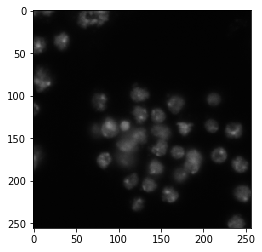

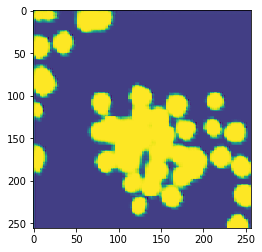

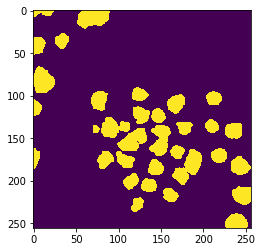

In [30]:
index=41
origin_height,origin_width=x_train[index].shape[0],x_train[index].shape[1]
cropped_pred = predict[index][0:origin_height, 0:origin_width].reshape((origin_height,origin_width))

plt.imshow(x_train[index])
plt.show()
plt.imshow(cropped_pred)
plt.show()
plt.imshow(y_train[index])
plt.show()

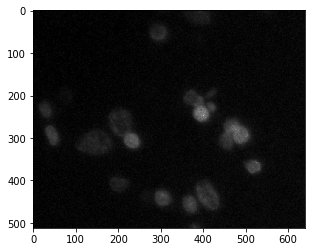

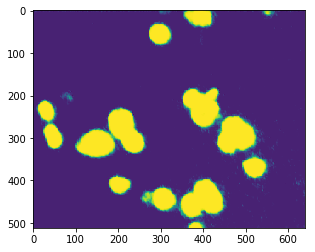

In [34]:
# index_test=35
index_test = 50
origin_height,origin_width=x_test[index_test].shape[0],x_test[index_test].shape[1]
cropped_pred = predict_test[index_test][0:origin_height, 0:origin_width].reshape((origin_height,origin_width))

plt.imshow(x_test[index_test])
plt.show()
plt.imshow(cropped_pred)
plt.show()